### Importing Required Libraries

In [1]:
import torch
import os
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import random
import cv2

### Exploring the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data_path='/content/drive/MyDrive/processed/PRECISE_Hackathon_Dataset'
data_classes=os.listdir(data_path)
data_classes

['normal', 'malignant', 'benign']

In [ ]:
for sub_class in data_classes:
  sub_folder_path=os.path.join(data_path,sub_class)
  files=len(glob.glob(f'{sub_folder_path}/*.png'))
  print(f'The total no. of files in {sub_class} directory: {files}')

The total no. of files in normal directory: 246
The total no. of files in malignant directory: 400
The total no. of files in benign directory: 854


#### Combining the masks when a case has more than two masks
*Only run if there is not processsed folder *

In [ ]:
# more_than_one_masks=glob.glob(data_path+'/*/*mask_*.png')
# more_than_one_masks

In [ ]:
# mask_dict={}
# for img in more_than_one_masks:
#   ind=img.split("mask")[0].split('/')[-1]
#   if ind not in mask_dict:
#     mask_dict[ind]=[]
#     mask_dict[ind].append(img)
#   else:
#     mask_dict[ind].append(img)
#mask_dict

In [ ]:
# for element in mask_dict:
#     length=len(mask_dict[element])
#     if length==1:
#         second_mask=mask_dict[element][0]
#         orig_mask=second_mask.replace("_1","")
#         mask_1=cv2.imread(orig_mask,cv2.IMREAD_GRAYSCALE)
#         mask_2=cv2.imread(second_mask,cv2.IMREAD_GRAYSCALE)
#         combined_mask=cv2.bitwise_or(mask_1,mask_2)
#         print(combined_mask.shape)
#         cv2.imwrite(orig_mask,combined_mask)
#         os.remove(second_mask)
#     if length==2:
#         second_mask=mask_dict[element][0]
#         orig_mask=second_mask.replace("_1","")
#         third_mask=mask_dict[element][1]
#         mask_1=cv2.imread(orig_mask,cv2.IMREAD_GRAYSCALE)
#         mask_2=cv2.imread(second_mask,cv2.IMREAD_GRAYSCALE)
#         mask_3=cv2.imread(third_mask,cv2.IMREAD_GRAYSCALE)
#         combined_mask1=cv2.bitwise_or(mask_1,mask_2)
#         combined_mask2=cv2.bitwise_or(combined_mask1,mask_3)
#         print(combined_mask1.shape)
#         cv2.imwrite(orig_mask,combined_mask2)
#         os.remove(second_mask)
#         os.remove(third_mask)


### DataLoader and Datset

In [ ]:
mask_images=glob.glob(data_path+'/*/*mask.png')
scan_images=[image.replace("_mask","") for image in mask_images]
series=list(zip(scan_images,mask_images))

In [ ]:
dataset=pd.DataFrame(series,columns=["image_path","mask_path"])
dataset.head(5)

,image_path,mask_path
0,/content/drive/MyDrive/processed/PRECISE_Hacka...,/content/drive/MyDrive/processed/PRECISE_Hacka...
1,/content/drive/MyDrive/processed/PRECISE_Hacka...,/content/drive/MyDrive/processed/PRECISE_Hacka...
2,/content/drive/MyDrive/processed/PRECISE_Hacka...,/content/drive/MyDrive/processed/PRECISE_Hacka...
3,/content/drive/MyDrive/processed/PRECISE_Hacka...,/content/drive/MyDrive/processed/PRECISE_Hacka...
4,/content/drive/MyDrive/processed/PRECISE_Hacka...,/content/drive/MyDrive/processed/PRECISE_Hacka...


In [ ]:
class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
          #Normalization
            img = self.image_transform(image)
            mean=torch.mean(img)
            std=torch.std(img)
            norm=transforms.Normalize(mean,std)
            image=norm(img)
            mask = self.image_transform(mask)


        return image, mask

In [ ]:

IMAGE_SIZE=128
BATCH_SIZE=8

data_transforms=transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train, test= train_test_split(dataset, test_size=0.2)

train_dataset = CustomImageMaskDataset(train, data_transforms)
test_dataset = CustomImageMaskDataset(test, data_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Data Visualization




In [ ]:
def plot_images(data):

  #Testing Preprocessing
    # img_path=Image.open(image_mask[0]).convert('L')
    #color_jitter=transforms.ColorJitter(brightness=0.5, contrast=0.5)
    # image_arr = np.array(img_path)
    # mean=np.mean(image_arr)
    # std=np.median(image_arr)

    # nv=transforms.Compose([
    #     transforms.ColorJitter(brightness=0.5, contrast=0.5),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=[mean], std=[std])])

    # trans_img=nv(img_path)
    # image=trans_img.numpy()

    #trans = Image.open(trans_img_path).convert('L')
    #m=Image.open(image_mask[1]).convert()

    image=cv2.imread(data[0])
    mask = cv2.imread(data[1])

    fig, ax = plt.subplots(1, 3, figsize=(7, 7))

    ax[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    ax[0].set_ylabel('Axial View', fontsize=14)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Scan', fontsize=14)

    ax[1].imshow(np.squeeze(mask), cmap='gray', origin='lower')
    ax[1].axis('off')
    ax[1].set_title('Overlay', fontsize=14)

    ax[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    ax[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    ax[2].axis('off')
    ax[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()

    plt.show()

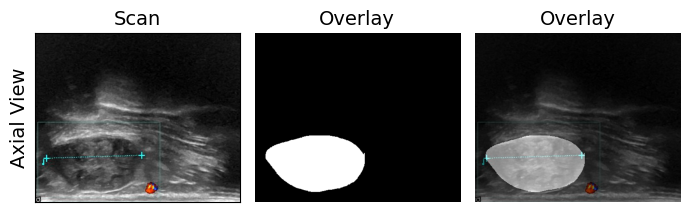

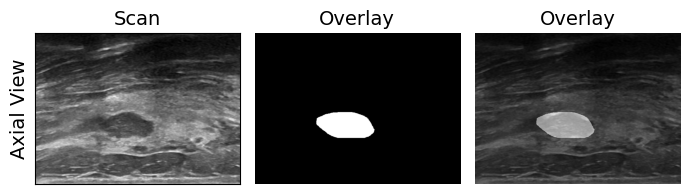

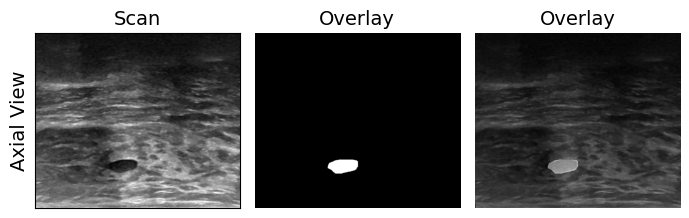

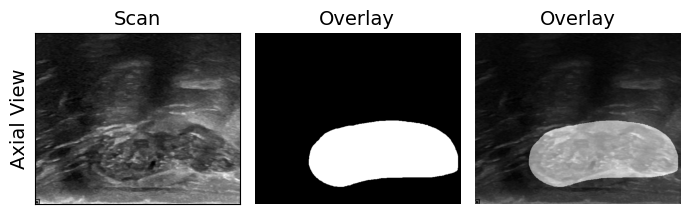

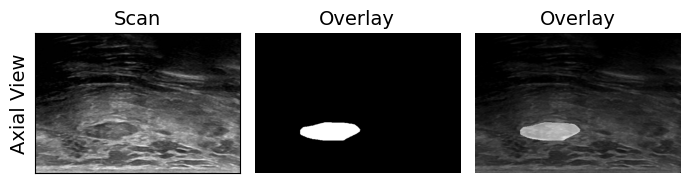

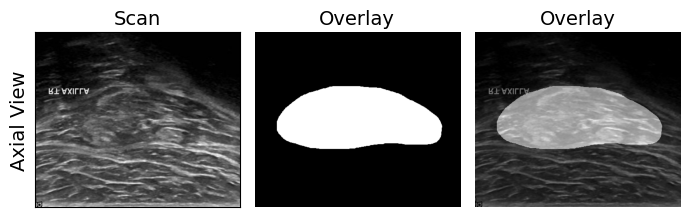

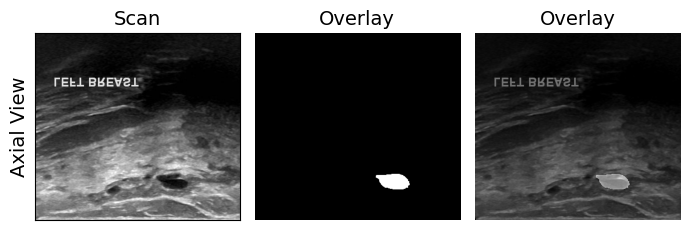

In [ ]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_images(series[image])

### Baseline model Architecture-> UNET

In [4]:

class DoubleConvBlock(nn.Module): #singleXdropout
    def __init__(self, input_channel, out_channel, dropout):
        super(DoubleConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)

        x = self.dropout(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout): ##2Xdropout
        super(Encoder, self).__init__()
        self.conv2d_1 = DoubleConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):#2X dropout
      #bifurcation: tracking dynamics -> todo
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = DoubleConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [5]:
class Unet(nn.Module):

    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.1)
        self.encoder_2 = Encoder(64, 128, 0.5)
        self.encoder_3 = Encoder(128, 256, 0.5)
        self.encoder_4 = Encoder(256, 512, 0.5)

        self.conv_block = DoubleConvBlock(512, 1024, 0.6)

        self.decoder_1 = Decoder(1024, 512, 0.5)
        self.decoder_2 = Decoder(512, 256, 0.5)
        self.decoder_3 = Decoder(256, 128, 0.5)
        self.decoder_4 = Decoder(128, 64, 0.1)

        self.cls = nn.Conv2d(64, 1, kernel_size=1,padding=0)
        self.relu = nn.Sigmoid()

    def forward(self, x):

        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)


        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)

        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final


### Training Baseline Model

#### class

In [6]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device,scheduler):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15
        self.scheduler=scheduler


        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        #
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice


    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)
                #place where adopt the optuna
                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')
            self.scheduler.step()

            # Validation
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,

            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [7]:
def dice_coef_loss(inputs, target):
    smooth = 1
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score

In [7]:
model = Unet(1).to(device)

In [ ]:
learning_rate = 0.001
weight_decay = 1e-5 # Regularization term to prevent overfitting

optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)

trainer = Trainer(model=model, num_epochs=50, optimizer=optimizer, criterion=bce_dice_loss, device=device,scheduler=scheduler)

In [ ]:
trainer.train(train_dataloader, val_dataloader)


Epoch [1/50], Step [15/75], Loss: 1.3185, Dice Coef: 0.1700
Epoch [1/50], Step [30/75], Loss: 1.2162, Dice Coef: 0.1542
Epoch [1/50], Step [45/75], Loss: 1.2245, Dice Coef: 0.0419
Epoch [1/50], Step [60/75], Loss: 1.1930, Dice Coef: 0.0868
Epoch [1/50], Step [75/75], Loss: 1.1126, Dice Coef: 0.2418
Epoch [1/50], Train Loss: 1.2748, Val Loss: 1.1342
Epoch [1/50], Train Dice: 0.1331, Val Dice: 0.1969
Epoch [2/50], Step [15/75], Loss: 1.0209, Dice Coef: 0.2390
Epoch [2/50], Step [30/75], Loss: 0.9229, Dice Coef: 0.2825
Epoch [2/50], Step [45/75], Loss: 0.9315, Dice Coef: 0.3123
Epoch [2/50], Step [60/75], Loss: 0.7833, Dice Coef: 0.4384
Epoch [2/50], Step [75/75], Loss: 0.9614, Dice Coef: 0.3325
Epoch [2/50], Train Loss: 0.9664, Val Loss: 0.9762
Epoch [2/50], Train Dice: 0.2905, Val Dice: 0.4070
Epoch [3/50], Step [15/75], Loss: 0.6475, Dice Coef: 0.4872
Epoch [3/50], Step [30/75], Loss: 0.6397, Dice Coef: 0.5101
Epoch [3/50], Step [45/75], Loss: 0.6370, Dice Coef: 0.4603
Epoch [3/50], St

In [ ]:
metrics = trainer.get_metrics()

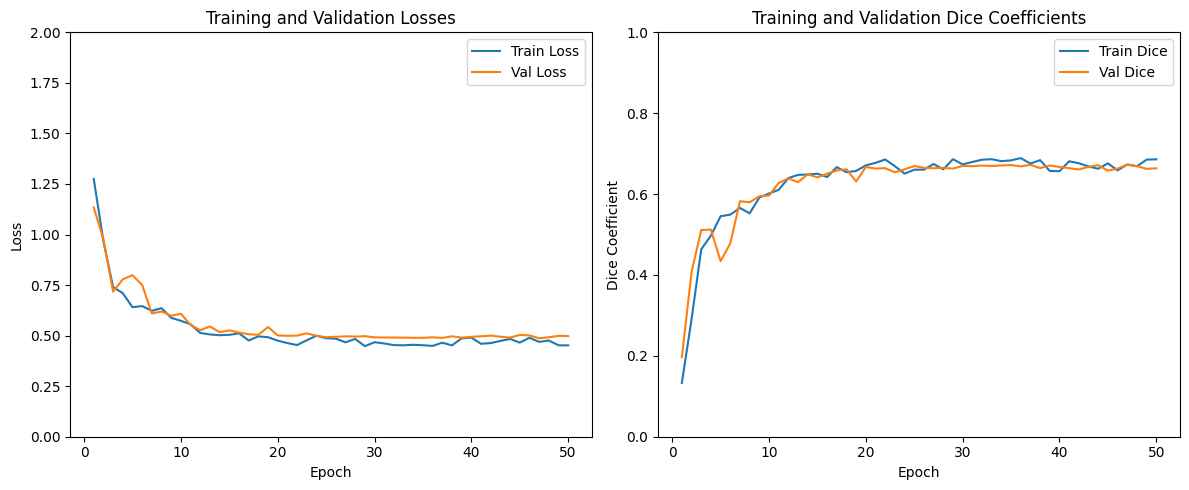

In [ ]:
def to_numpy(tensor):
    # only use if its tensor
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 2)
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


In [ ]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)

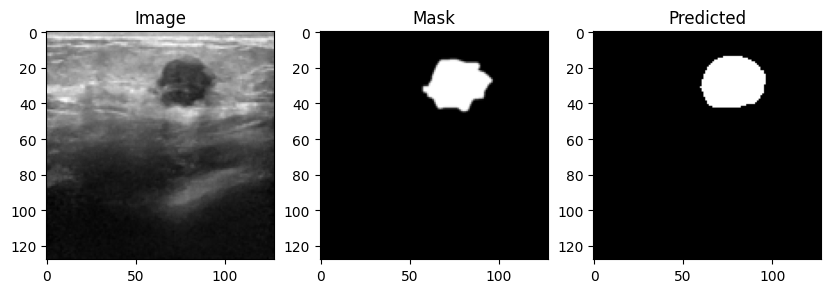

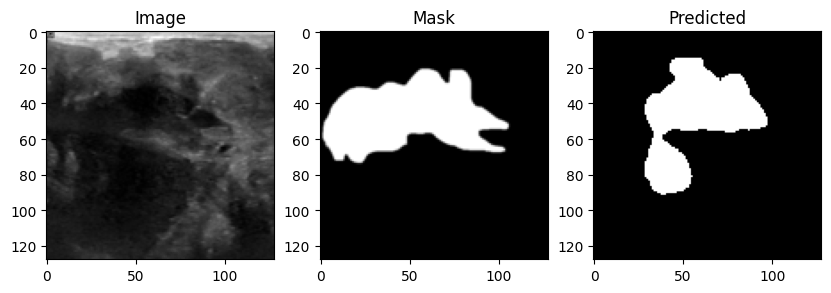

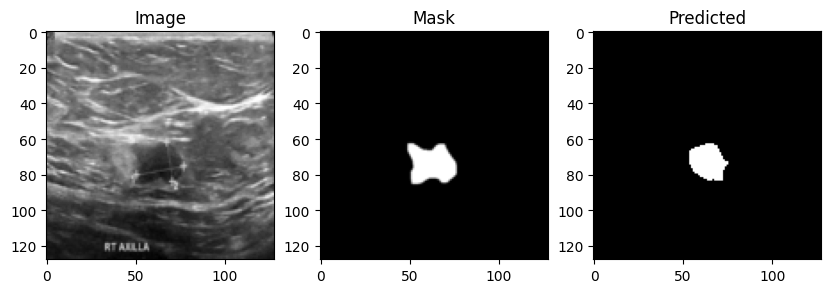

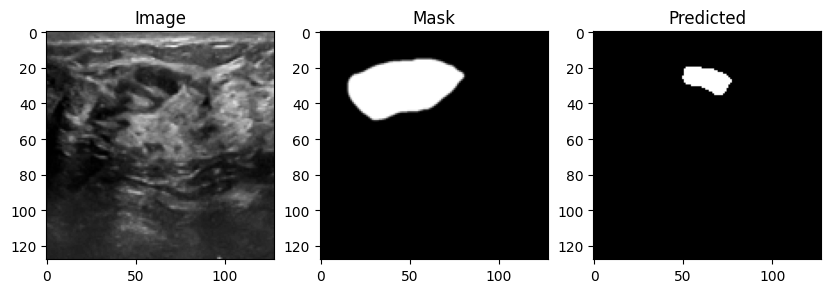

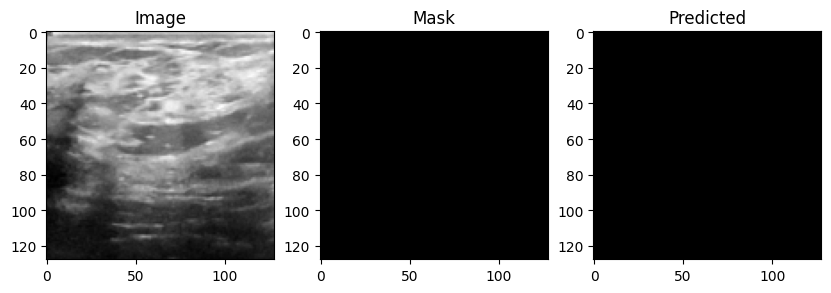

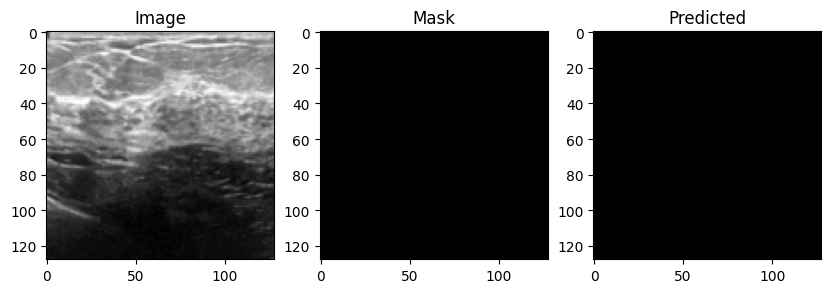

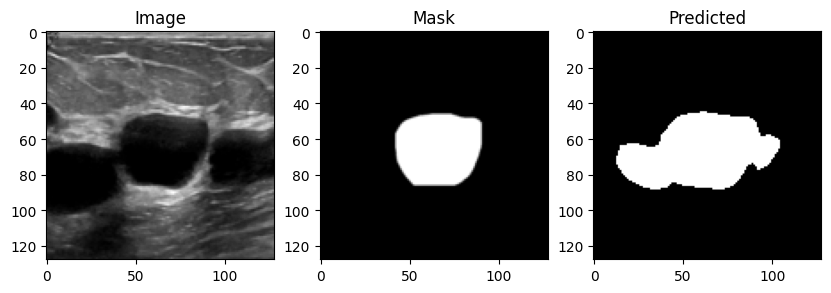

In [ ]:
for i in [2, 3, 11, 20, 55, 67, 87]:
    image = test_dataset[i][0]
    mask = test_dataset[i][1]
    im = image.to(device)
    pred = model(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

#### Optuna

In [ ]:
import optuna


In [ ]:
#optuna implementation
def objective(trial):
  unet = Unet(1).to(device)
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
  weight_decay= trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)  # Regularization term to prevent overfitting

  optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)
  trainer_optuna = Trainer(model=unet, num_epochs=20, optimizer=optimizer, criterion=bce_dice_loss, device=device,scheduler=scheduler)
  trainer_optuna.train(train_dataloader, val_dataloader)
  metrics_optuna = trainer_optuna.get_metrics()


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

[I 2024-09-21 20:14:36,632] A new study created in memory with name: no-name-d3c4e2d8-7c81-4f66-9ba1-41b70d52f99c
<ipython-input-35-156301f94d70>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
<ipython-input-35-156301f94d70>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay= trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)  # Regularization term to prevent overfitting


Epoch [1/20], Step [15/75], Loss: 1.0207, Dice Coef: 0.2537
Epoch [1/20], Step [30/75], Loss: 0.8470, Dice Coef: 0.3316
Epoch [1/20], Step [45/75], Loss: 0.7848, Dice Coef: 0.4452
Epoch [1/20], Step [60/75], Loss: 1.0062, Dice Coef: 0.2584
Epoch [1/20], Step [75/75], Loss: 0.9817, Dice Coef: 0.1672
Epoch [1/20], Train Loss: 0.9624, Val Loss: 0.8660
Epoch [1/20], Train Dice: 0.3226, Val Dice: 0.3979
Epoch [2/20], Step [15/75], Loss: 0.6629, Dice Coef: 0.5211
Epoch [2/20], Step [30/75], Loss: 1.0794, Dice Coef: 0.2200
Epoch [2/20], Step [45/75], Loss: 0.9921, Dice Coef: 0.3282
Epoch [2/20], Step [60/75], Loss: 1.0656, Dice Coef: 0.2146
Epoch [2/20], Step [75/75], Loss: 0.8403, Dice Coef: 0.3947
Epoch [2/20], Train Loss: 0.7791, Val Loss: 0.8007
Epoch [2/20], Train Dice: 0.4502, Val Dice: 0.4461
Epoch [3/20], Step [15/75], Loss: 0.8923, Dice Coef: 0.4056
Epoch [3/20], Step [30/75], Loss: 0.9826, Dice Coef: 0.3049
Epoch [3/20], Step [45/75], Loss: 0.8598, Dice Coef: 0.3043
Epoch [3/20], St

[W 2024-09-21 20:19:31,862] Trial 0 failed with parameters: {'learning_rate': 0.00335003756181109, 'weight_decay': 5.956520701351294e-05} because of the following error: The value None could not be cast to float..
[W 2024-09-21 20:19:31,864] Trial 0 failed with value None.


Epoch [20/20], Train Loss: 0.5741, Val Loss: 0.6447
Epoch [20/20], Train Dice: 0.5986, Val Dice: 0.5730


**Attention Unet**

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)

        x = self.dropout(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x


class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(output_channel * 2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)

        # Attention gate for the skip connection
        self.attention_gate = AttentionGate(F_g=output_channel, F_l=output_channel, F_int=output_channel // 2)

    def forward(self, x, skip):
        x = self.conv_t(x)

        # Apply the attention gate before concatenating the skip connection
        skip = self.attention_gate(x, skip)

        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

class AttentionUnet(nn.Module):

    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.1)
        self.encoder_2 = Encoder(64, 128, 0.5)
        self.encoder_3 = Encoder(128, 256, 0.5)
        self.encoder_4 = Encoder(256, 512, 0.5)

        self.conv_block = ConvBlock(512, 1024, 0.6)

        # Decoder with Attention Gate
        self.decoder_1 = Decoder(1024, 512, 0.5)
        self.decoder_2 = Decoder(512, 256, 0.5)
        self.decoder_3 = Decoder(256, 128, 0.5)
        self.decoder_4 = Decoder(128, 64, 0.1)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid()

    def forward(self, x):

        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)

        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final


**Running a few epochs**

In [9]:
att_unet = AttentionUnet(1).to(device)

In [ ]:
learning_rate = 0.001
weight_decay = 1e-6 # Regularization term to prevent overfitting

optimizer = optim.Adam(att_unet.parameters(), lr=learning_rate,weight_decay=weight_decay)

scheduler = lr_scheduler.StepLR(optimizer, step_size=30,gamma=0.1)

att_unet_trainer = Trainer(model=att_unet, num_epochs=5, optimizer=optimizer, criterion=bce_dice_loss, device=device,scheduler=scheduler)

In [ ]:
att_unet_trainer.train(train_dataloader, val_dataloader)
att_metrics = att_unet_trainer.get_metrics()

Epoch [1/5], Step [15/75], Loss: 0.9431, Dice Coef: 0.3150
Epoch [1/5], Step [30/75], Loss: 0.9007, Dice Coef: 0.3826
Epoch [1/5], Step [45/75], Loss: 0.7104, Dice Coef: 0.4544
Epoch [1/5], Step [60/75], Loss: 0.7913, Dice Coef: 0.3955
Epoch [1/5], Step [75/75], Loss: 0.9013, Dice Coef: 0.3140
Epoch [1/5], Train Loss: 0.8720, Val Loss: 2.0465
Epoch [1/5], Train Dice: 0.3597, Val Dice: 0.3083
Epoch [2/5], Step [15/75], Loss: 0.8056, Dice Coef: 0.3980
Epoch [2/5], Step [30/75], Loss: 0.9225, Dice Coef: 0.4240
Epoch [2/5], Step [45/75], Loss: 0.7061, Dice Coef: 0.4700
Epoch [2/5], Step [60/75], Loss: 0.7280, Dice Coef: 0.3974
Epoch [2/5], Step [75/75], Loss: 1.0367, Dice Coef: 0.2996
Epoch [2/5], Train Loss: 0.6980, Val Loss: 0.8312
Epoch [2/5], Train Dice: 0.5010, Val Dice: 0.4748
Epoch [3/5], Step [15/75], Loss: 0.4842, Dice Coef: 0.6016
Epoch [3/5], Step [30/75], Loss: 0.5444, Dice Coef: 0.5789
Epoch [3/5], Step [45/75], Loss: 0.4699, Dice Coef: 0.6771
Epoch [3/5], Step [60/75], Loss: 

**Loading the final trained model and running a few inferences**

In [10]:
# Initialize the model
trained_att_model = AttentionUnet(1).to(device)

# Load the saved state_dict
pretrained_path = "/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/final_saved_best_model.pth"
pretrained_weights = torch.load(pretrained_path, map_location=device)

# Load the weights into the model
trained_att_model.load_state_dict(pretrained_weights)
trained_att_model.eval()

<ipython-input-10-b3ee6e5892a4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(pretrained_path, map_location=device)


AttentionUnet(
  (encoder_1): Encoder(
    (conv2d_1): ConvBlock(
      (conv2d_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_1): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2d_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_2): ReLU()
    )
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_2): Encoder(
    (conv2d_1): ConvBlock(
      (conv2d_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_1): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
      (co

In [11]:
# Initialize the model
trained_att_model = AttentionUnet(1).to(device)


# Load the saved state_dict
pretrained_path = "/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/final_saved_best_model.pth"
pretrained_weights = torch.load(pretrained_path, map_location=device)

# Load the weights into the model
trained_att_model.load_state_dict(pretrained_weights)
trained_att_model.eval()


import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

masks = glob.glob("/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Evaluation_dataset/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]  # Replace "_mask" to get image paths
series = list(zip(images, masks))  # Zip image and mask paths together
print(len(series))

# Convert the image-mask pairs into a DataFrame for validation
validation_dataset_df = pd.DataFrame(series, columns=['image_path', 'mask_path'])


class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe  # DataFrame containing image and mask paths
        self.image_transform = image_transform  # Transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and mask paths
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        # Load images and convert to grayscale
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        # Apply transformations (if any)
        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask, mask_path

# Image transformations for validation
image_size = 128
val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),  # Convert to Tensor
])

# Create validation dataset and dataloader
validation_dataset = CustomImageMaskDataset(validation_dataset_df, val_transforms)
batch_size = 1
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Define Dice Coefficient Loss
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target * inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection / union)

# Binary Cross-Entropy and Dice Loss
def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score


def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted



from PIL import Image

# Function to evaluate the model on the validation dataset
def evaluate_model(model, dataloader, out, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    dice_loss_total = 0

    with torch.no_grad():
        for batch in dataloader:
            # Load images and masks from the batch
            images, masks, mask_path = batch
            images = images.to(device)
            masks = masks.to(device)


            save_dir = os.path.join(out, os.path.basename(mask_path[0]))
            print(save_dir)


            # Get model predictions
            outputs = model(images)

            # Threshold the predicted values
            outputs_sv = threshold_prediction(outputs, threshold=0.5).detach().cpu().numpy()


            numpy_array = outputs_sv.squeeze()
            mask = numpy_array.astype(np.uint8) * 255

            #image = Image.fromarray(mask)
            #print(mask.shape)

            #image.save(save_dir)
            cv2.imwrite(save_dir, mask)

            # Calculate Dice and BCE+Dice losses
            dice_loss = dice_coef_loss(outputs, masks)
            bce_dice = bce_dice_loss(outputs, masks)

            # Accumulate the total loss and dice loss
            total_loss += bce_dice.item()
            dice_loss_total += dice_loss.item()

    # Calculate average loss over the entire validation set
    avg_total_loss = total_loss / len(dataloader)
    avg_dice_loss = dice_loss_total / len(dataloader)

    return avg_total_loss, avg_dice_loss


    trained_att_model.to(device)


# Directory to save output segmentation masks
out = '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04'

# Create output directory if it doesn't exist
os.makedirs(out, exist_ok=True)

# Evaluate the model on the validation dataset
avg_total_loss, avg_dice_loss = evaluate_model(trained_att_model, validation_dataloader, out, device)

# Print the evaluation results
print(f"Average Total Loss (BCE + Dice): {avg_total_loss}")
print(f"Average Dice Loss: {avg_dice_loss}")


<ipython-input-11-c142271f086f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(pretrained_path, map_location=device)


30
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (1)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (10)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (3)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (4)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (2)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (6)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (5)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (8)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/normal (7)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hac

/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (9)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (5)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (8)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (7)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (6)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (2)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (3)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (4)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_4/Team_04/malignant (1)_mask.png
/content/drive/My D

In [12]:
masks = glob.glob("/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_4/Team_04/*_grnd.png")
images = [mask_images.replace("_grnd", "") for mask_images in masks]  # Replace "_mask" to get image paths
series = list(zip(images, masks))  # Zip image and mask paths together

#print(series)



# Convert the image-mask pairs into a DataFrame for validation
validation_dataset_df = pd.DataFrame(series, columns=['image_path', 'mask_path'])


class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe  # DataFrame containing image and mask paths
        self.image_transform = image_transform  # Transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and mask paths
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        # Load images and convert to grayscale
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        # Apply transformations (if any)
        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

# Image transformations for validation
image_size = 128
val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),  # Convert to Tensor
])

# Create validation dataset and dataloader
validation_dataset = CustomImageMaskDataset(validation_dataset_df, val_transforms)
batch_size = 1
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)



# Define Dice Coefficient Loss
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target * inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection / union)

# Binary Cross-Entropy and Dice Loss
def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score


def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted


# Function to evaluate the model on the validation dataset
def evaluate_model(dataloader, device):
    #model.eval()  # Set model to evaluation mode
    total_loss = 0
    dice_loss_total = 0

    with torch.no_grad():
        for batch in dataloader:
            # Load images and masks from the batch
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            # Get model predictions
            # outputs = model(images)

            # Threshold the predicted values
            #outputs = threshold_prediction(outputs, threshold=0.5)

            # Calculate Dice and BCE+Dice losses
            dice_loss = dice_coef_loss(images, masks)
            bce_dice = bce_dice_loss(images, masks)

            # Accumulate the total loss and dice loss
            total_loss += bce_dice.item()
            dice_loss_total += dice_loss.item()

    # Calculate average loss over the entire validation set
    avg_total_loss = total_loss / len(dataloader)
    avg_dice_loss = dice_loss_total / len(dataloader)

    return avg_total_loss, avg_dice_loss

# Evaluate the model on the validation dataset
avg_total_loss, avg_dice_loss = evaluate_model(validation_dataloader, device)

# Print the evaluation results
print(f"Average Total Loss (BCE + Dice): {avg_total_loss}")
print(f"Average Dice Loss: {avg_dice_loss}")

Average Total Loss (BCE + Dice): 27.43345069885254
Average Dice Loss: 0.763535737991333


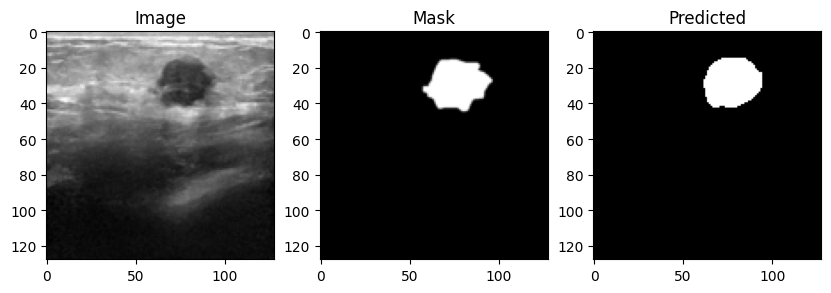

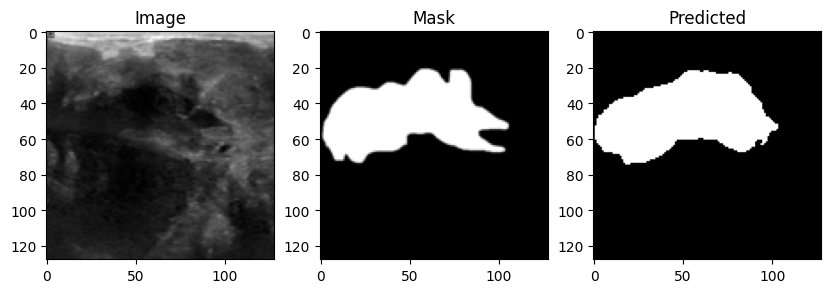

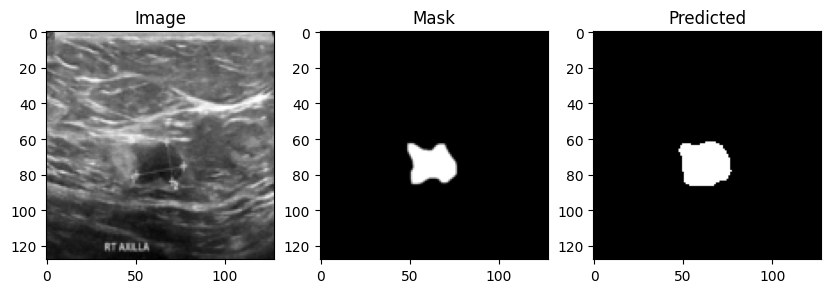

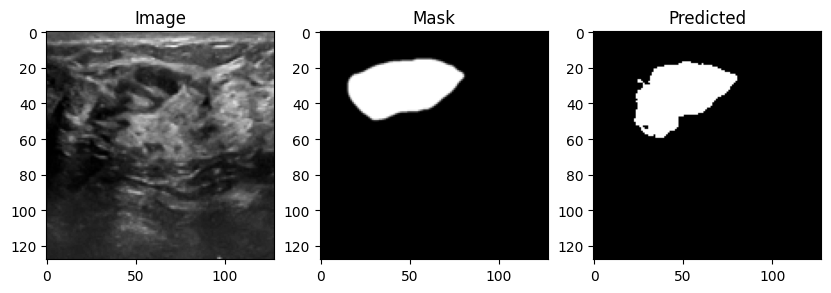

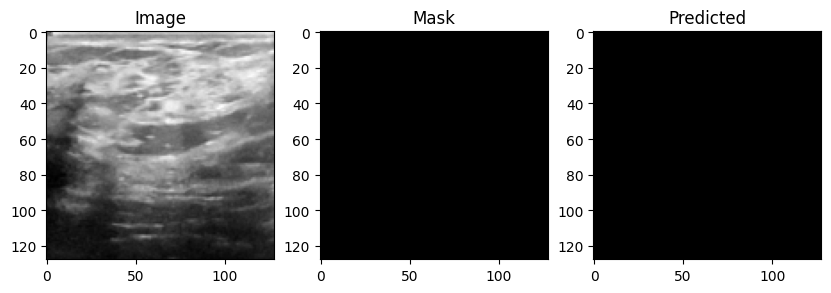

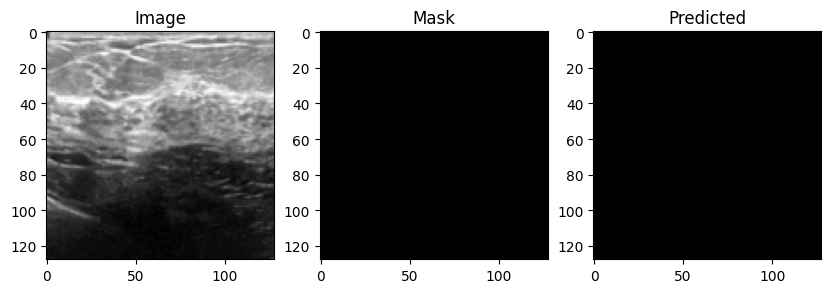

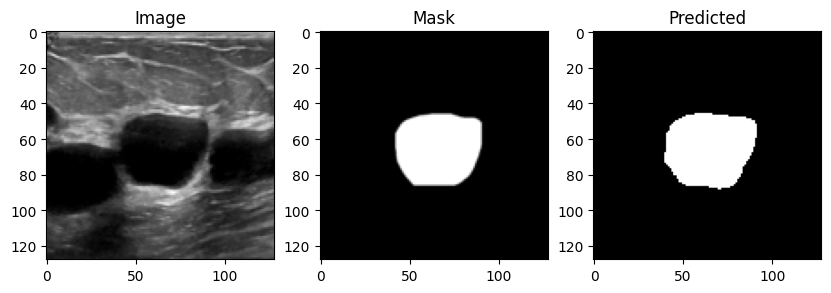